In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats.stats import pearsonr  
from scipy import signal
import statistics
from sklearn.metrics import mean_squared_error
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [ ]:
# data import
stockstring='NDAQ'

#datetime(year, month, day)
start_date = datetime(2019,1,1)
end_date  = datetime.today()

total_data = yf.download(stockstring, 
                      start=start_date, 
                      end=end_date,
                      progress=False)

correlation_ref_end = datetime.today()
correlation_ref_interval = 60
correlation_ref_start =  correlation_ref_end - timedelta(days=correlation_ref_interval)
correlation_prog_end =  correlation_ref_end + timedelta(days=correlation_ref_interval)

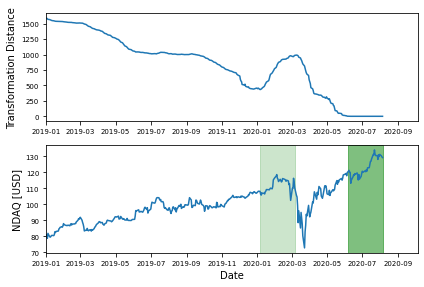

In [1]:
# calculate DTW

df = pd.DataFrame(total_data['Close'].tolist())
df['date'] = total_data.index
total_data_list=df[0].tolist()
total_data_len=len(df.index)

ref_data_df=df.loc[df['date'].between(correlation_ref_start,correlation_ref_end, inclusive=True)]
ref_data=ref_data_df[0].tolist()
ref_data_len=len(ref_data_df.index) 
correlations=np.zeros((total_data_len,2))

for time_step in range(0,total_data_len-ref_data_len):
    correlation_data= total_data_list[time_step:time_step+ref_data_len]
    distance, path = fastdtw(correlation_data, ref_data, dist=euclidean)
    correlations[time_step,0]  =  time_step
    correlations[time_step,1]  =  distance 


index_max = np.argmin(correlations[0:total_data_len-ref_data_len*2,1])
bestfit_date = df['date'][index_max]

prog_past_start_date = bestfit_date +  timedelta(days=correlation_ref_interval)
prog_past_end_date= prog_past_start_date +  timedelta(days=correlation_ref_interval)
prog_past_data_date_list = pd.date_range(prog_past_start_date, periods=ref_data_len, freq='B')
prog_past_data_df=df.loc[df['date'].between(prog_past_start_date,prog_past_end_date, inclusive=True)]


prog_present_end_date = datetime.today() +  timedelta(days=correlation_ref_interval)
prog_present_date_list_df = pd.date_range(datetime.today(), periods=ref_data_len, freq='B').to_frame()

total_data.head()
ticker = yf.Ticker(stockstring)
total_data = ticker.history(start=start_date, end=end_date)


In [ ]:
# data visualization
fig, axs = plt.subplots(2)
axs[1].plot(df['date'],df[0])
axs[1].axvspan(correlation_ref_start, correlation_ref_end, alpha=0.5, color='green')
axs[1].axvspan(bestfit_date, bestfit_date+timedelta(days=correlation_ref_interval), alpha=0.2, color='green')
axs[0].plot(df['date'],correlations[:,1])

plt.setp(axs, xlim=[start_date,prog_present_end_date])
# Set the formatting the same for both subplots
axs[0].tick_params(axis='both', which='both', labelsize=7)
axs[1].tick_params(axis='both', which='both', labelsize=7)

plt.setp(axs[1], xlabel='Date')
plt.setp(axs[0], ylabel='Transformation Distance')
plt.setp(axs[1], ylabel='NDAQ [USD]')

# set ticks visible, if using sharex = True. Not needed otherwise
for tick in axs[0].get_xticklabels():
    tick.set_visible(True)


plt.tight_layout()
plt.show()
